## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [9]:
import os
from pathlib import Path
import sys
import mne 
from mne.datasets import fetch_fsaverage
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


In [10]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / "Source Time Courses"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / "Functional Connectivity"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Get CLBP WSP from viable subject IDs

In [11]:
# viable subjects
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

# CP Subs with widespread pain
widespread_pain_CP = [
    '055',
    '052',
    '046',
    '039',
    '036',
    '031',
    '022',
    '045',
    '040',
    '034',
    '032',
    '024',
    '018'
]

# Sort and limit CP subs to only those with widespread pain
widespread_pain_CP.sort()
sub_ids_CP_WSP = widespread_pain_CP

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Combine selected CP and HC subjects
sub_ids = sub_ids_CP_WSP + sub_ids_HC

# Exclude subjects with NaN source localization
NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids = [sub for sub in sub_ids if sub not in NAN_SUBS]

exclude_resting=True

# These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
# TODO: estimate eyes open timestamps from alpha band power
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

In [12]:
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

print(f"Chronics: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"Total: {len(sub_ids)}")

Chronics: 11
['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Controls: 17
['C6.', 'C7.', 'C9.', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C24', 'C25', 'C26', 'C27']
Total: 28


### Get CLBP without WSP from viable sub IDs

In [13]:
# Chronic Pain Subs without widespread pain
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_No_WSP = [el for el in sub_ids if el.startswith('0')]

NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NAN_SUBS]

NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NO_KEYPRESS]

# Not in WSP
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in sub_ids_CP_WSP]

print(f"Chronics with widespread pain: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Chronics without widespread pain: {len(sub_ids_CP_No_WSP)}")
print([sub for sub in sub_ids_CP_No_WSP])


Chronics with widespread pain: 11
['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Chronics without widespread pain: 22
['020', '023', '027', '029', '030', '033', '035', '037', '038', '041', '042', '043', '044', '048', '049', '050', '051', '053', '054', '056', '057', '058']


### Define ROIs, frequency bands, conditions, and methods for FC

In [14]:
# Get stc only from selected labels
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "ACC-lh", "S1-lh", "insula-lh", "dlPFC-lh", "mOFC-lh",
                "rACC-rh", "ACC-rh", "S1-rh", "insula-rh", "dlPFC-rh", "mOFC-rh"]

Freq_Bands = {
    # 'delta': [0, 4],
    "theta": [4.0, 8.0],
    "alpha": [8.0, 13.0],
    "beta": [13.0, 30.0],
    "low-gamma": [30.0, 58.5],
    # "notch": [58.5, 61.5],
    "high-gamma": [61.5, 100.0],
}
band_names = [band for band in Freq_Bands]

sfreq = 400  # Hz
tmin, tmax = 0.0, 1.5  # exclude the baseline period for connectivity estimation

# TODO: replace con methods and conditions once testing complete
con_methods = [
#   "wpli2_debiased",
#   "dpli",
  "aec_pairwise",
  "aec_symmetric",
]

# Include intermediate stimulus?
include_LS = False

conditions = (
    [
        "Hand 32 mN",
        "Hand LS",
        "Hand 256 mN",
        "Back 32 mN",
        "Back LS",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        # "Eyes Open",
        # "Eyes Closed",
    ]
)

groups=['Chronic Pain with Widespread Pain','Chronic Pain', 'Healthy Control']

### Compute functional connectivity for each subject in each group

In [15]:
# CLBP with WSP
sub_con_CP_WSP = {}
for sub_id in sub_ids_CP_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_WSP[sub_id] = sub_avg_cons


utils.clear_display()

022
Reading stimulus labels and pain ratings for Subject 022...

*stim_labels length = 56*
*pain_ratings_raw length = 56*

+----------------+--------------+
| Subject        | 022          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | theta        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 022           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 024           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setti

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 024           |
+----------------+---------------+
| Condition      | Hand 256 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 024           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parame

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 032          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 4            |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+--

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter len

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 032           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 4             |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up ban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setti

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 036          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 036           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 036           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
-------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.2

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.5

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 046           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-----------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 046           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 046           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 052          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 052           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed t

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

In [16]:
# CLBP without WSP
sub_con_CP_No_WSP = {}
for sub_id in sub_ids_CP_No_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain wo WSP",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_No_WSP[sub_id] = sub_avg_cons
utils.clear_display()

020
Reading stimulus labels and pain ratings for Subject 020...

*stim_labels length = 80*
*pain_ratings_raw length = 80*

+----------------+--------------+
| Subject        | 020          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 20           |
+----------------+--------------+
| Band           | theta        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter len

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.5

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.2

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripp

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting u

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cut

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parame

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 033          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting u

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 035           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 037          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 9            |
+----------------+--------------+
| Band           | high-gamma   |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 038          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 038           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-----------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 041          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 041          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
--------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)



Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 041          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | high-gamma   |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
----------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 041           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 041           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 042           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 042           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*dat

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 042           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 043          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 043          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 043          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cuto

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 043          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | high-gamma   |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 043           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 043           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 044          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 5            |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 044          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 5            |
+----------------+--------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 044           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 5             |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
-------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 044           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 5             |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parame

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 048          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 048          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 048           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 049          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter leng

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 049          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 049          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
--------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 049           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 049           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FI

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-----------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpa

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.2

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 053          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 053           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FI

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 058           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 9             |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FI

In [17]:
# Healthy Control group
sub_con_HC = {}
for sub_id in sub_ids_HC:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Healthy Control",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_HC[sub_id] = sub_avg_cons
utils.clear_display()

C6.
Reading stimulus labels and pain ratings for Subject C6....

*stim_labels length = 52*
*pain_ratings_raw length = 52*

+----------------+--------------+
| Subject        | C6.          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | theta        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C6.           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C7.          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C7.           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C9.          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C9.          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C10          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C10           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
--------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C10           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripp

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C12          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setti

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C12           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C13           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-----------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C13           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C13           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C14          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting u

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting u

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C17          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C17          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C17          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
--------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C17           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | beta          |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C18          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Set

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Sett

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Se

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.5

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C24           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter len

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C26          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 20           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
-------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting u

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C26          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 20           |
+----------------+--------------+
| Band           | beta         |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-6 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting u

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)


*data shape = (12, 12)*
+----------------+--------------+
| Subject        | C27          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 8            |
+----------------+--------------+
| Band           | high-gamma   |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 407 samples (1.018 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.2

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (407) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax)
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: f

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | C27           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 8             |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-6 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parame

In [22]:
# Stack the connectivity of all subjects in each group
group_con_CP_WSP = fc.compute_group_con(sub_con_CP_WSP, conditions, con_methods, band_names)
group_con_CP_No_WSP = fc.compute_group_con(sub_con_CP_No_WSP, conditions, con_methods, band_names)
group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)

In [23]:
save_flag = True

if save_flag:
    # Save/checkpoint as pickle
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_WSP.pkl", sub_con_CP_WSP)
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_No_WSP.pkl", sub_con_CP_No_WSP)
    utils.pickle_data(save_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)

    utils.pickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl", group_con_CP_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_No_WSP.pkl", group_con_CP_No_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_HC.pkl", group_con_HC)

Saved sub_con_Widespread_Pain_CP_WSP.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved sub_con_Widespread_Pain_CP_No_WSP.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved sub_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved group_con_Widespread_Pain_CP_WSP.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved group_con_Widespread_Pain_CP_No_WSP.pkl to ../../Data/Functional Connectivity/Widespread_Pain.
Saved group_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity/Widespread_Pain.


### Plot and compute satistics to assess statistical differences 

In [26]:
# Plot brain for AEC measure
plot_brain=False

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_pairwise - theta
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| S1-rh <-> dlPFC-rh |  0.019  | 0.281 ± 0.019  | 0.232 ± 0.012  |
| dlPFC-rh <-> S1-rh |  0.019  | 0.281 ± 0.019  | 0.232 ± 0.012  |
+--------------------+---------+----------------+----------------+


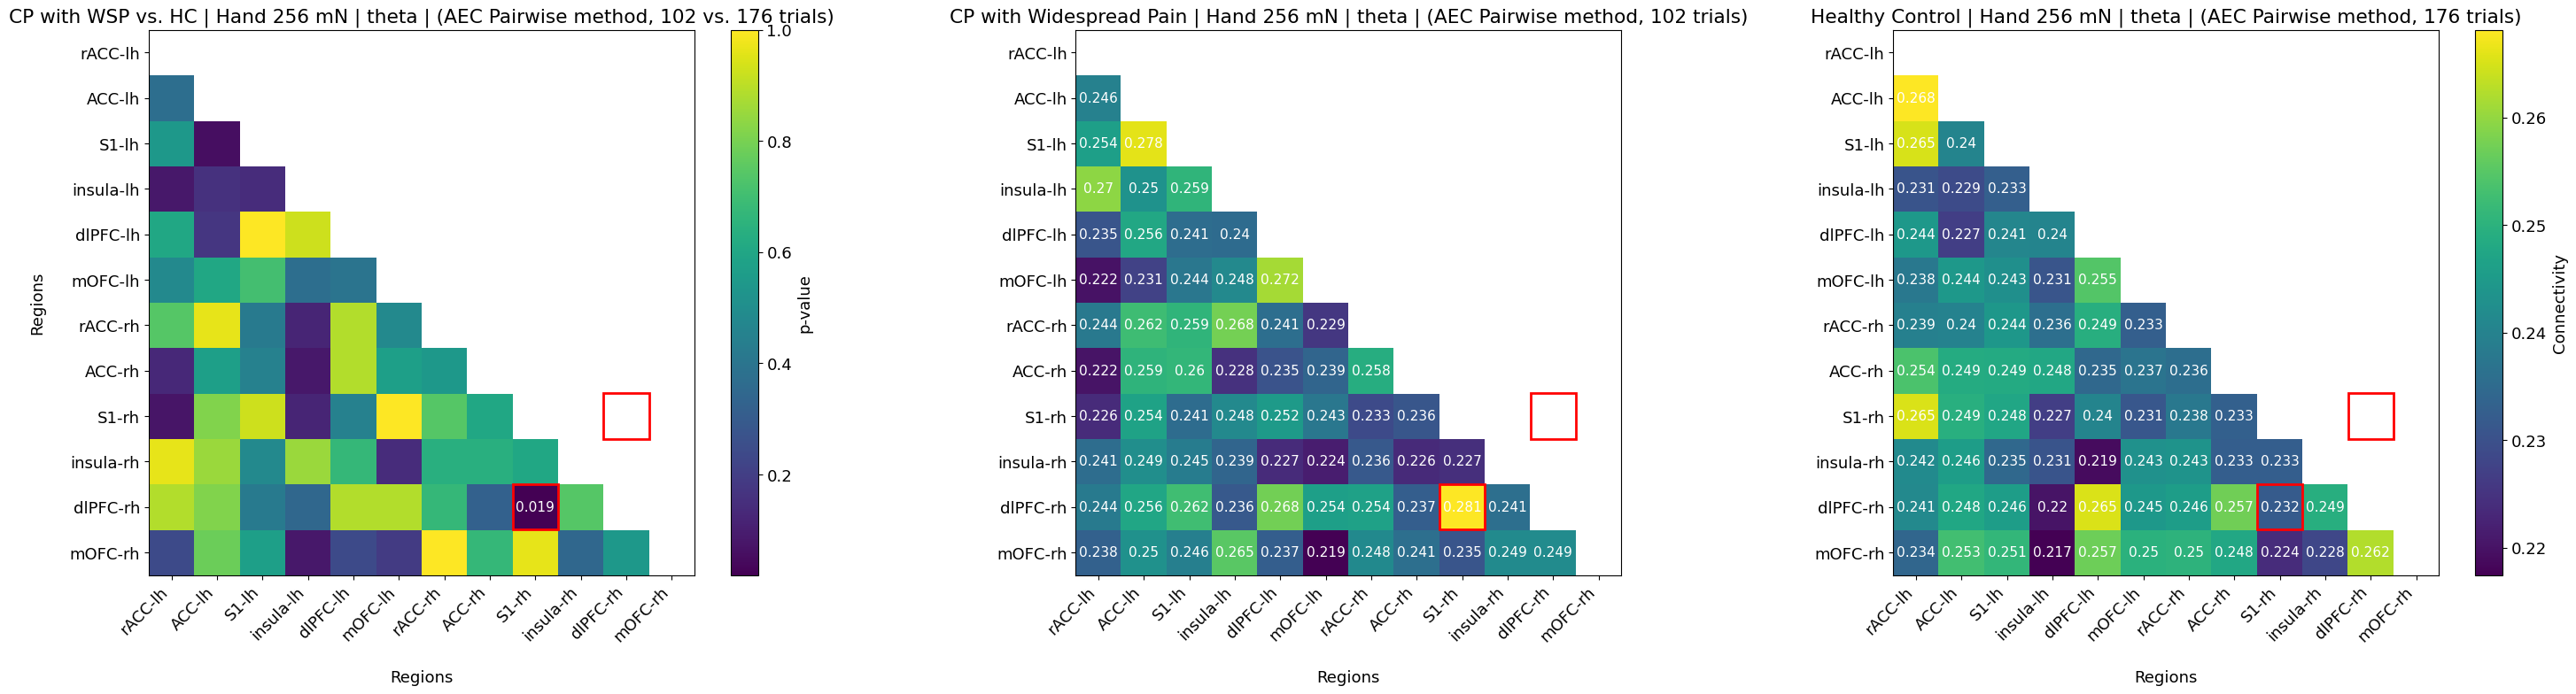

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_pairwise - alpha
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| ACC-lh <-> insula-lh  |  0.011  | 0.196 ± 0.011  |  0.23 ± 0.008  |
| insula-lh <-> ACC-lh  |  0.011  | 0.196 ± 0.011  |  0.23 ± 0.008  |
| insula-lh <-> rACC-rh |  0.038  |  0.199 ± 0.01  | 0.221 ± 0.008  |
|  insula-lh <-> S1-rh  |  0.03   | 0.246 ± 0.014  | 0.217 ± 0.007  |
| dlPFC-lh <-> dlPFC-rh |  0.048  |  0.21 ± 0.015  | 0.247 ± 0.009  |
|  mOFC-lh <-> mOFC-rh  |  0.048  | 0.204 ± 0.014  | 0.236 ± 0.008  |
| rACC-rh <-> insula-lh |  0.038  |  0.199 ± 0.01  | 0.221 ± 0.008  |
|   rACC-rh <-> S1-rh   |  0.034  |  0.208 ± 0.01  | 0.233 ± 0.008  |
| rACC-rh <-> dlPFC-rh  |  0.043  |  0.189 ± 0.01  | 0.209 ± 0.006  |
|  ACC-rh <-> mOFC-rh   |  0.024  | 0.266 ± 0.019  | 0.219 ± 0.013  |
|  S1-rh 

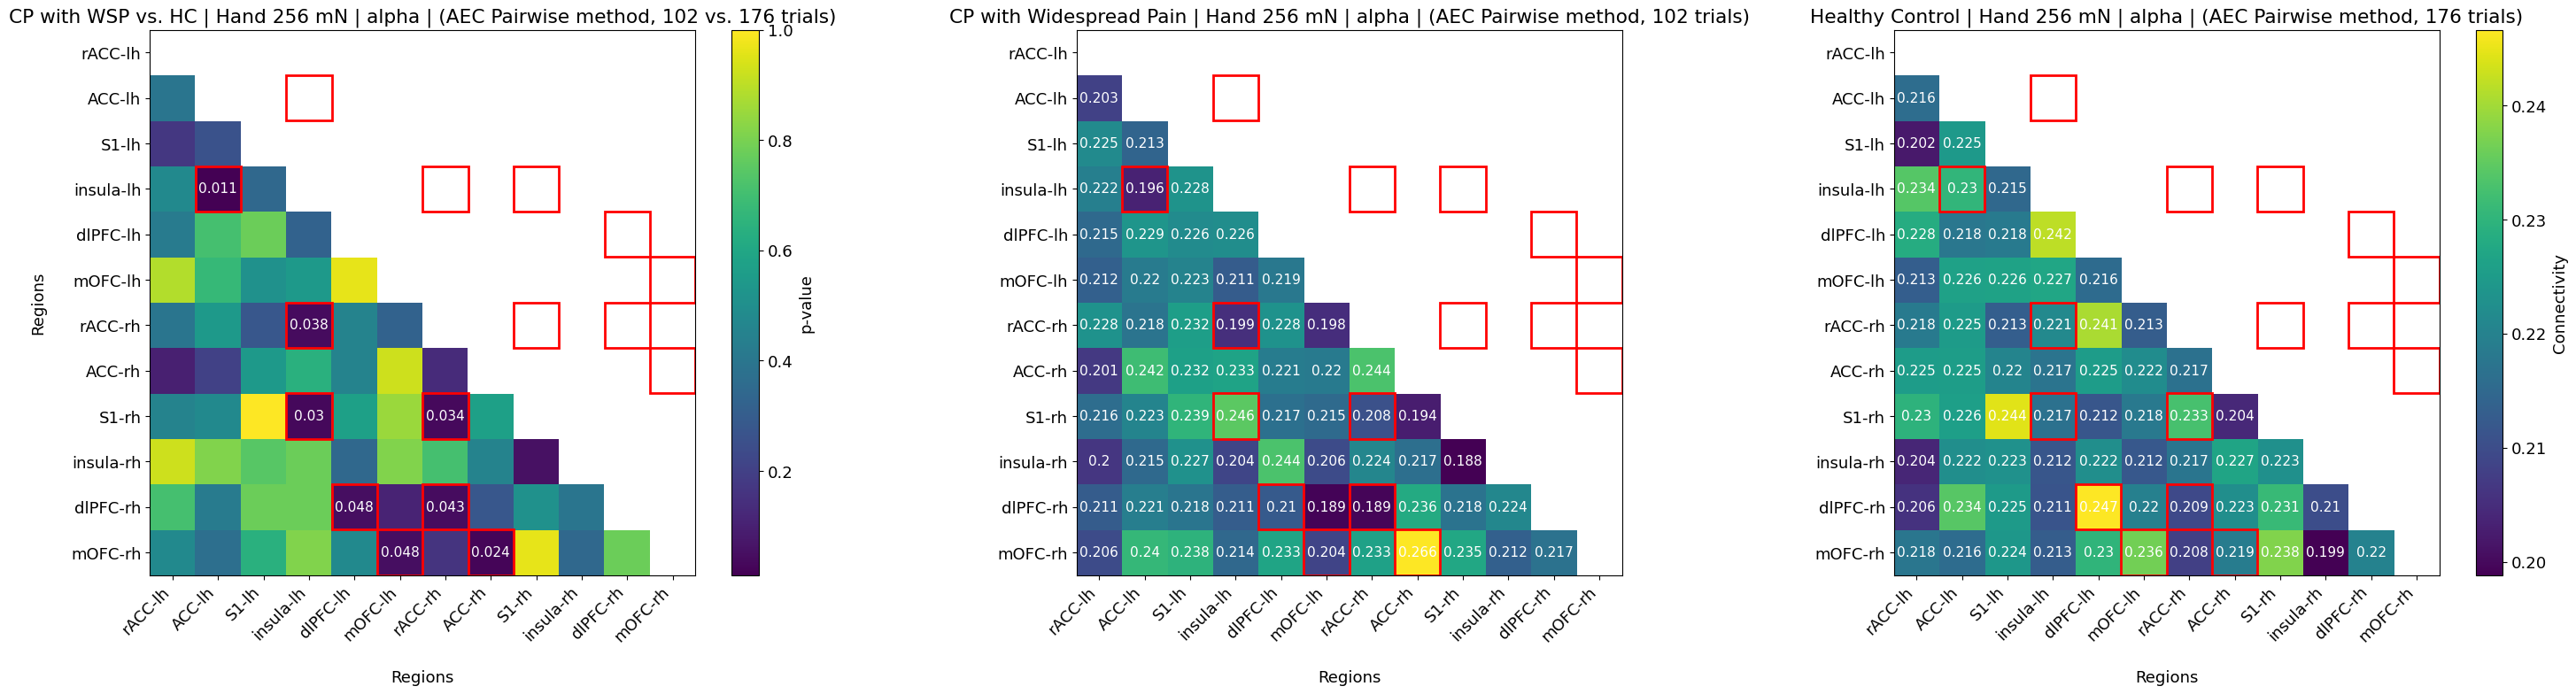

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_pairwise - beta
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|   ACC-lh <-> S1-lh    |  0.038  | 0.158 ± 0.009  |  0.133 ± 0.01  |
|   S1-lh <-> ACC-lh    |  0.038  | 0.158 ± 0.009  |  0.133 ± 0.01  |
|  dlPFC-lh <-> ACC-rh  |  0.043  | 0.139 ± 0.009  | 0.119 ± 0.006  |
| dlPFC-lh <-> dlPFC-rh |  0.048  | 0.122 ± 0.008  | 0.144 ± 0.007  |
|  mOFC-lh <-> ACC-rh   |  0.024  | 0.111 ± 0.009  |  0.14 ± 0.008  |
| rACC-rh <-> dlPFC-rh  |  0.021  | 0.127 ± 0.005  |  0.15 ± 0.007  |
|  ACC-rh <-> dlPFC-lh  |  0.043  | 0.139 ± 0.009  | 0.119 ± 0.006  |
|  ACC-rh <-> mOFC-lh   |  0.024  | 0.111 ± 0.009  |  0.14 ± 0.008  |
| dlPFC-rh <-> dlPFC-lh |  0.048  | 0.122 ± 0.008  | 0.144 ± 0.007  |
| dlPFC-rh <-> rACC-rh  |  0.021  | 0.127 ± 0.005  |  0.15 ± 0.007  |
+---------

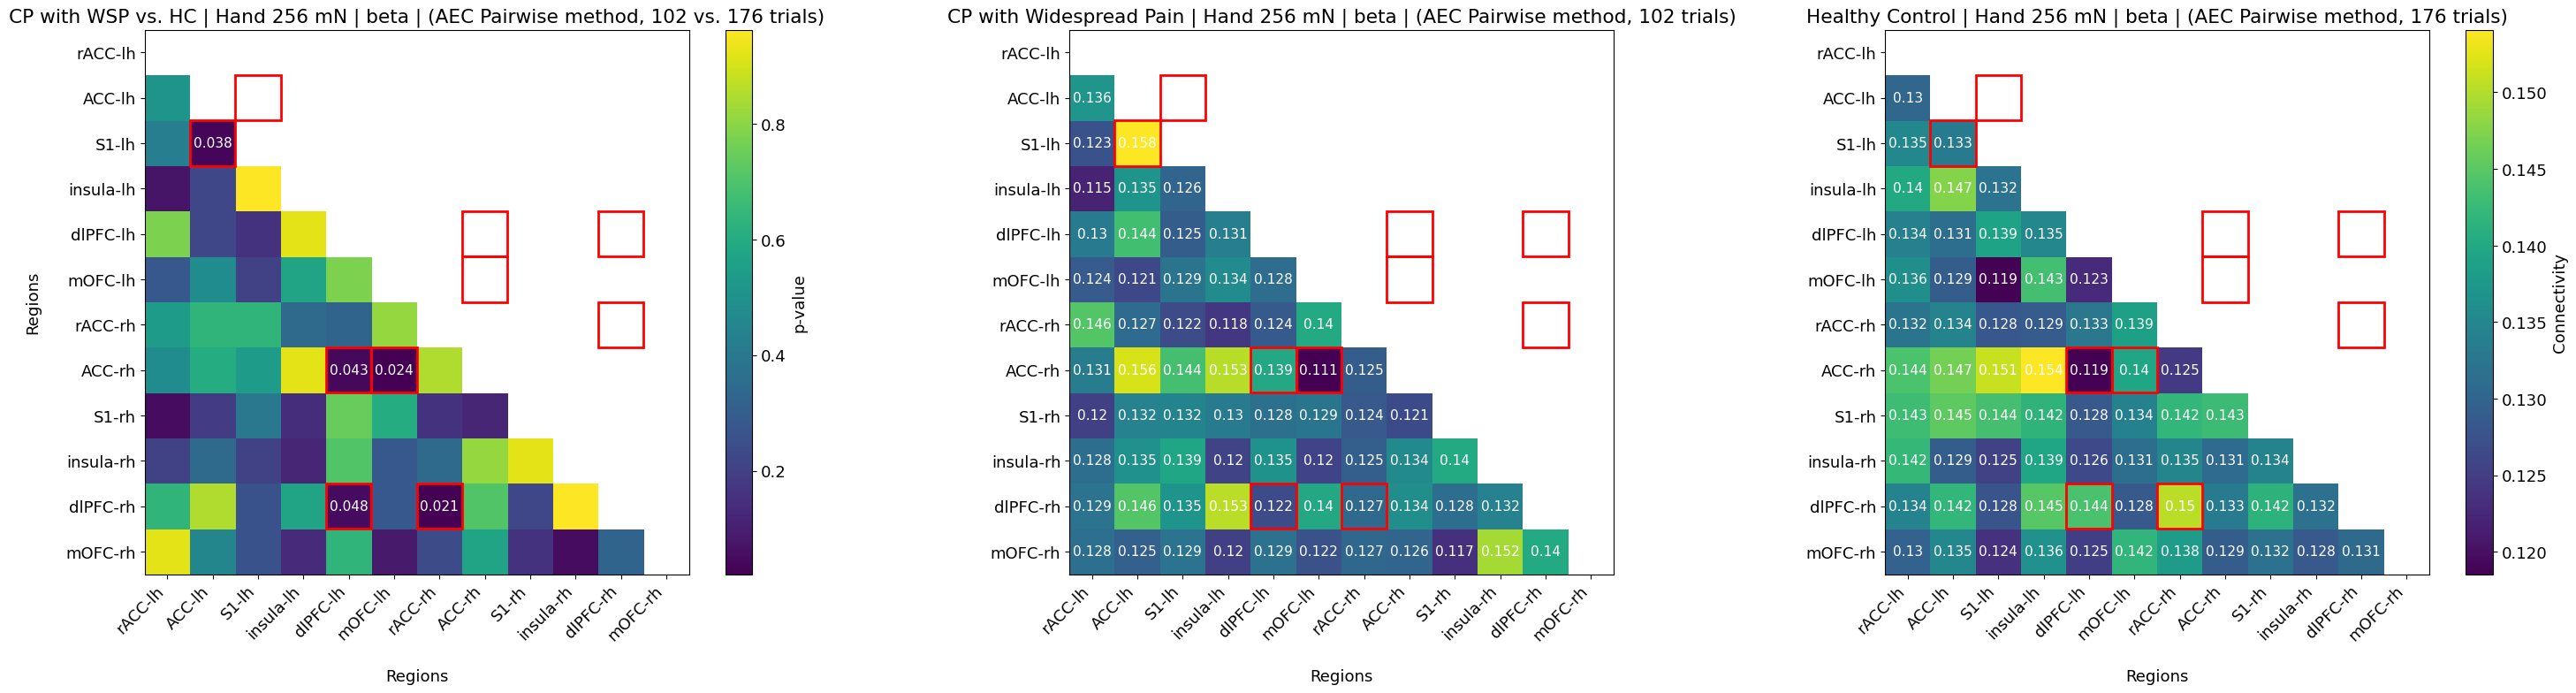

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_pairwise - low-gamma
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|  ACC-lh <-> dlPFC-lh  |  0.019  | 0.089 ± 0.003  | 0.106 ± 0.007  |
|   ACC-lh <-> ACC-rh   |  0.021  | 0.101 ± 0.005  | 0.118 ± 0.004  |
|  dlPFC-lh <-> ACC-lh  |  0.019  | 0.089 ± 0.003  | 0.106 ± 0.007  |
| mOFC-lh <-> insula-rh |  0.016  | 0.107 ± 0.005  | 0.091 ± 0.005  |
|   ACC-rh <-> ACC-lh   |  0.021  | 0.101 ± 0.005  | 0.118 ± 0.004  |
| insula-rh <-> mOFC-lh |  0.016  | 0.107 ± 0.005  | 0.091 ± 0.005  |
+-----------------------+---------+----------------+----------------+


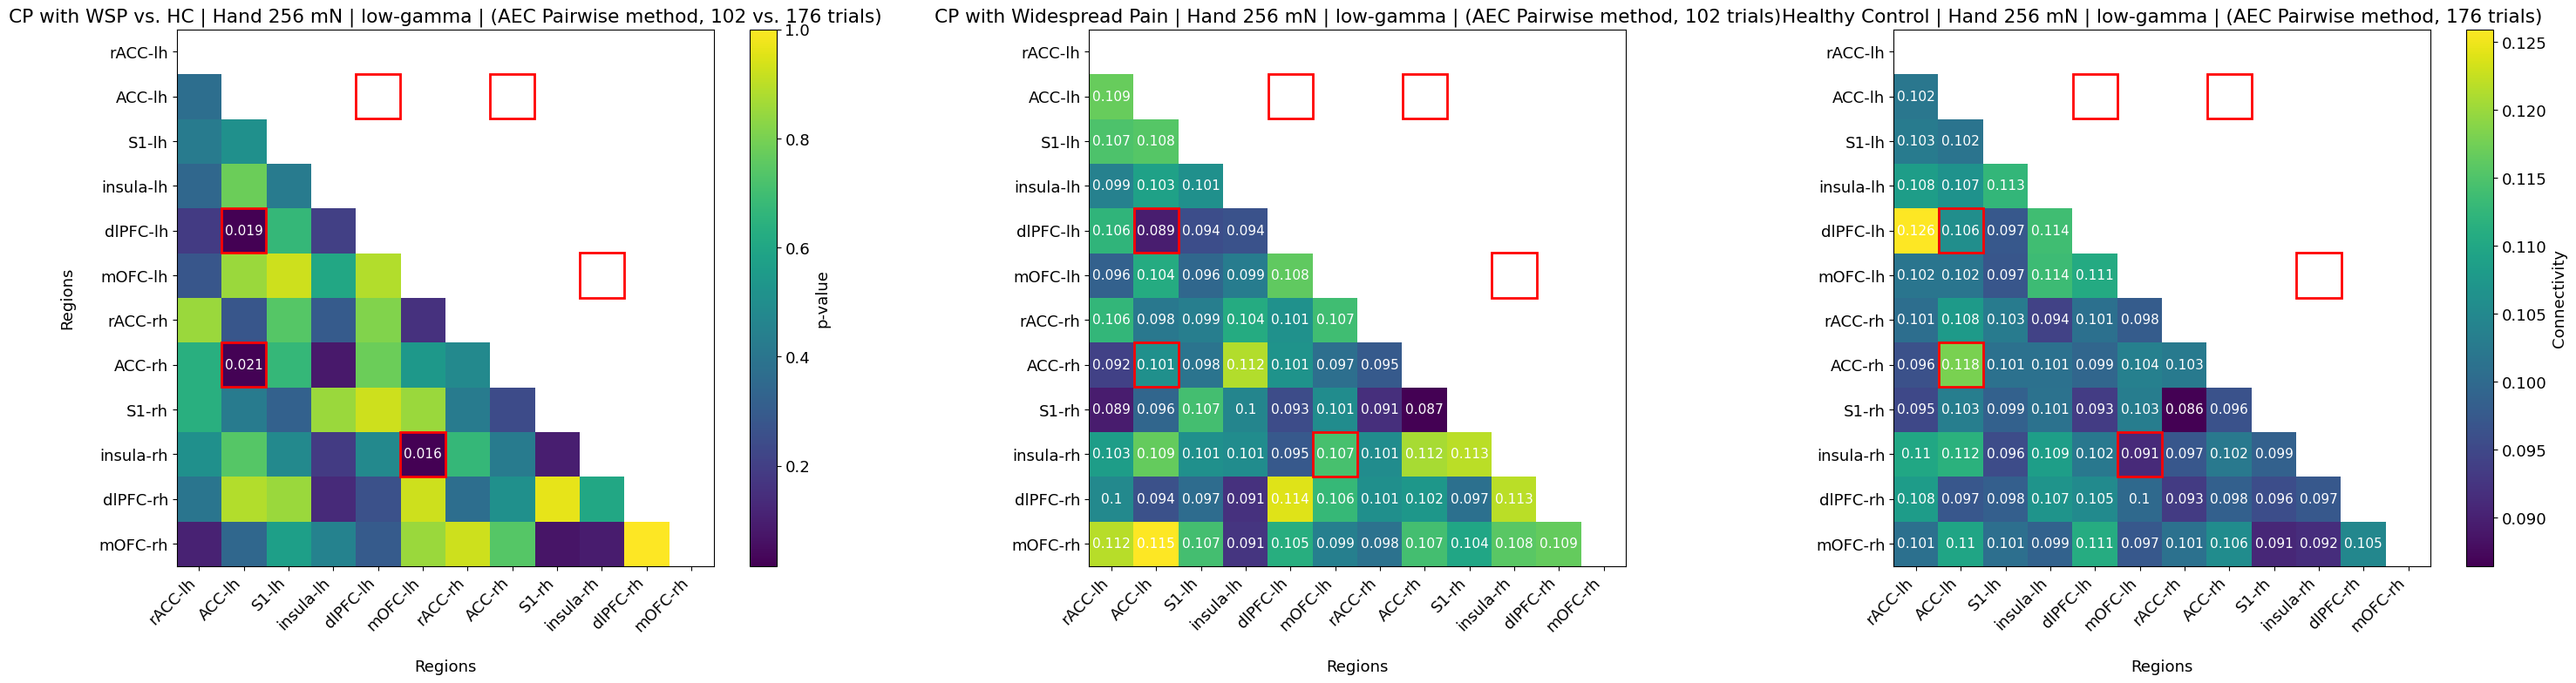

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_pairwise - high-gamma
+----------------------+---------+----------------+----------------+
|       ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+----------------------+---------+----------------+----------------+
| rACC-lh <-> dlPFC-lh |  0.038  |  0.08 ± 0.005  | 0.095 ± 0.004  |
|  rACC-lh <-> ACC-rh  |  0.048  | 0.076 ± 0.004  | 0.094 ± 0.006  |
|   ACC-lh <-> S1-lh   |  0.006  | 0.104 ± 0.007  | 0.076 ± 0.005  |
|   S1-lh <-> ACC-lh   |  0.006  | 0.104 ± 0.007  | 0.076 ± 0.005  |
|  S1-lh <-> dlPFC-lh  |  0.03   | 0.097 ± 0.006  | 0.087 ± 0.006  |
|  S1-lh <-> rACC-rh   |  0.034  | 0.071 ± 0.006  | 0.089 ± 0.004  |
| dlPFC-lh <-> rACC-lh |  0.038  |  0.08 ± 0.005  | 0.095 ± 0.004  |
|  dlPFC-lh <-> S1-lh  |  0.03   | 0.097 ± 0.006  | 0.087 ± 0.006  |
|  dlPFC-lh <-> S1-rh  |  0.043  |  0.09 ± 0.005  | 0.078 ± 0.003  |
|  rACC-rh <-> S1-lh   |  0.034  | 0.071 ± 0.006  | 0.089 ± 0.004  |
|  ACC-rh <-> rAC

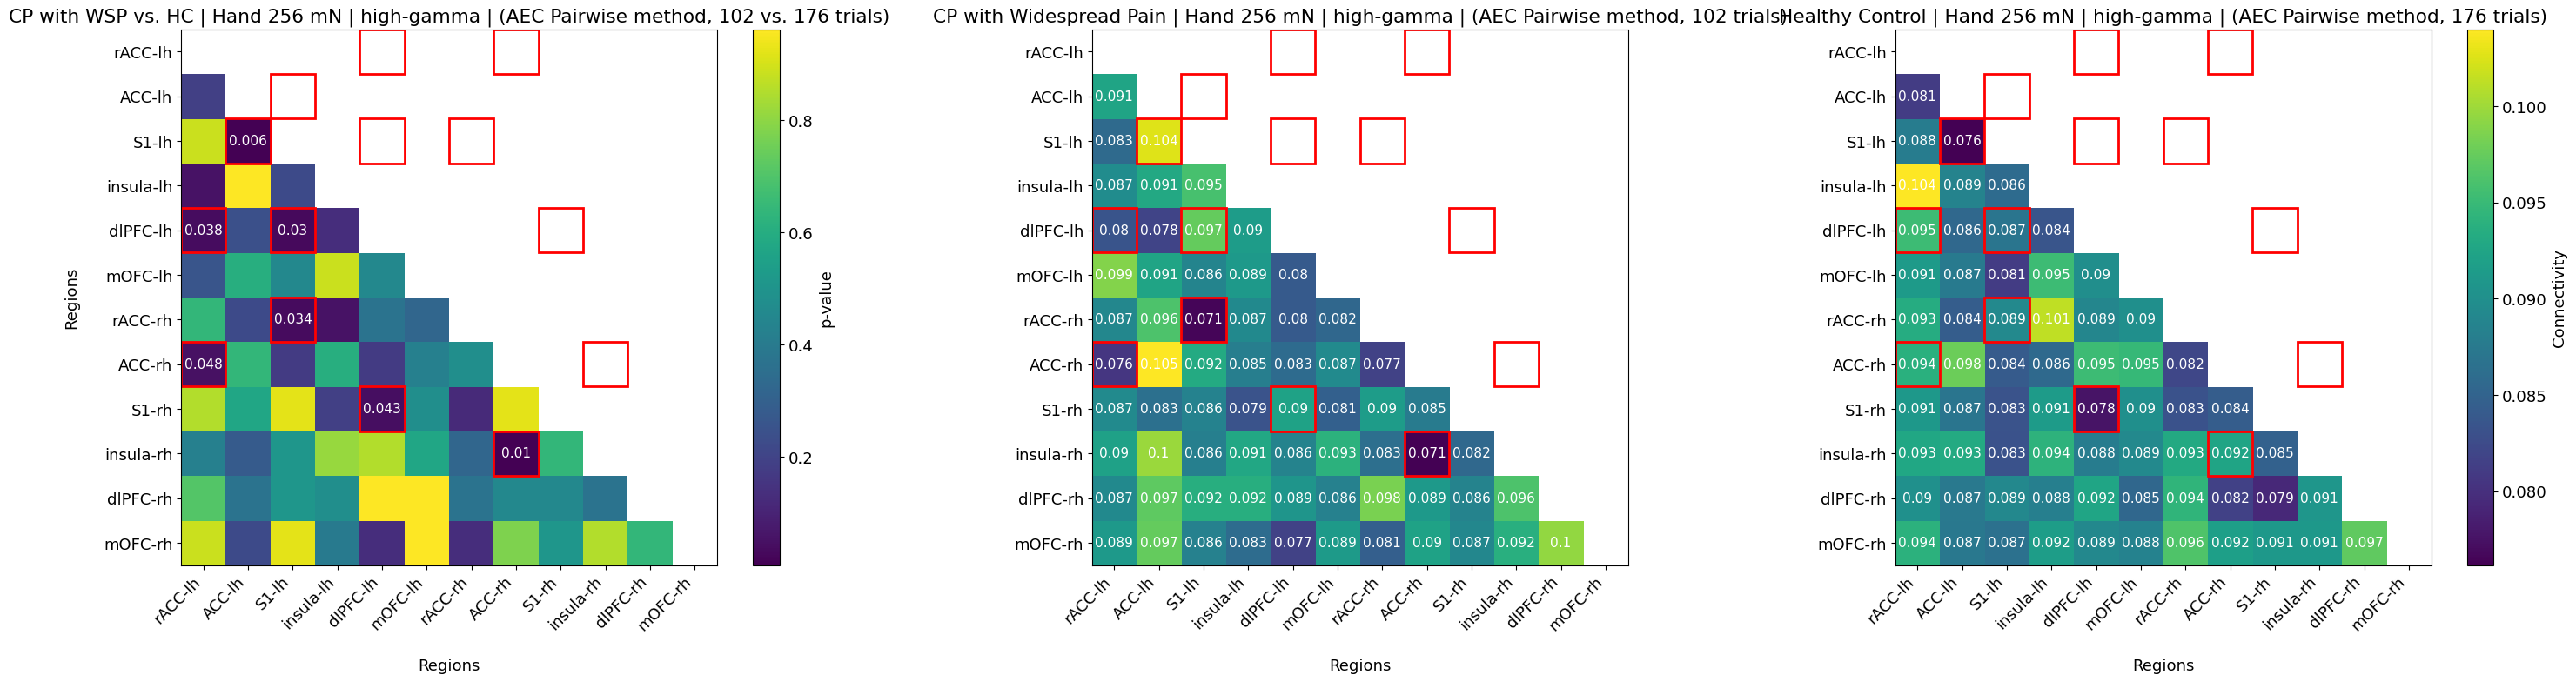

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_symmetric - theta
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| rACC-lh <-> insula-rh |  0.019  | 0.094 ± 0.026  | 0.172 ± 0.022  |
|   rACC-rh <-> S1-rh   |  0.021  | 0.146 ± 0.022  | 0.086 ± 0.019  |
|   S1-rh <-> rACC-rh   |  0.021  | 0.146 ± 0.022  | 0.086 ± 0.019  |
| insula-rh <-> rACC-lh |  0.019  | 0.094 ± 0.026  | 0.172 ± 0.022  |
+-----------------------+---------+----------------+----------------+


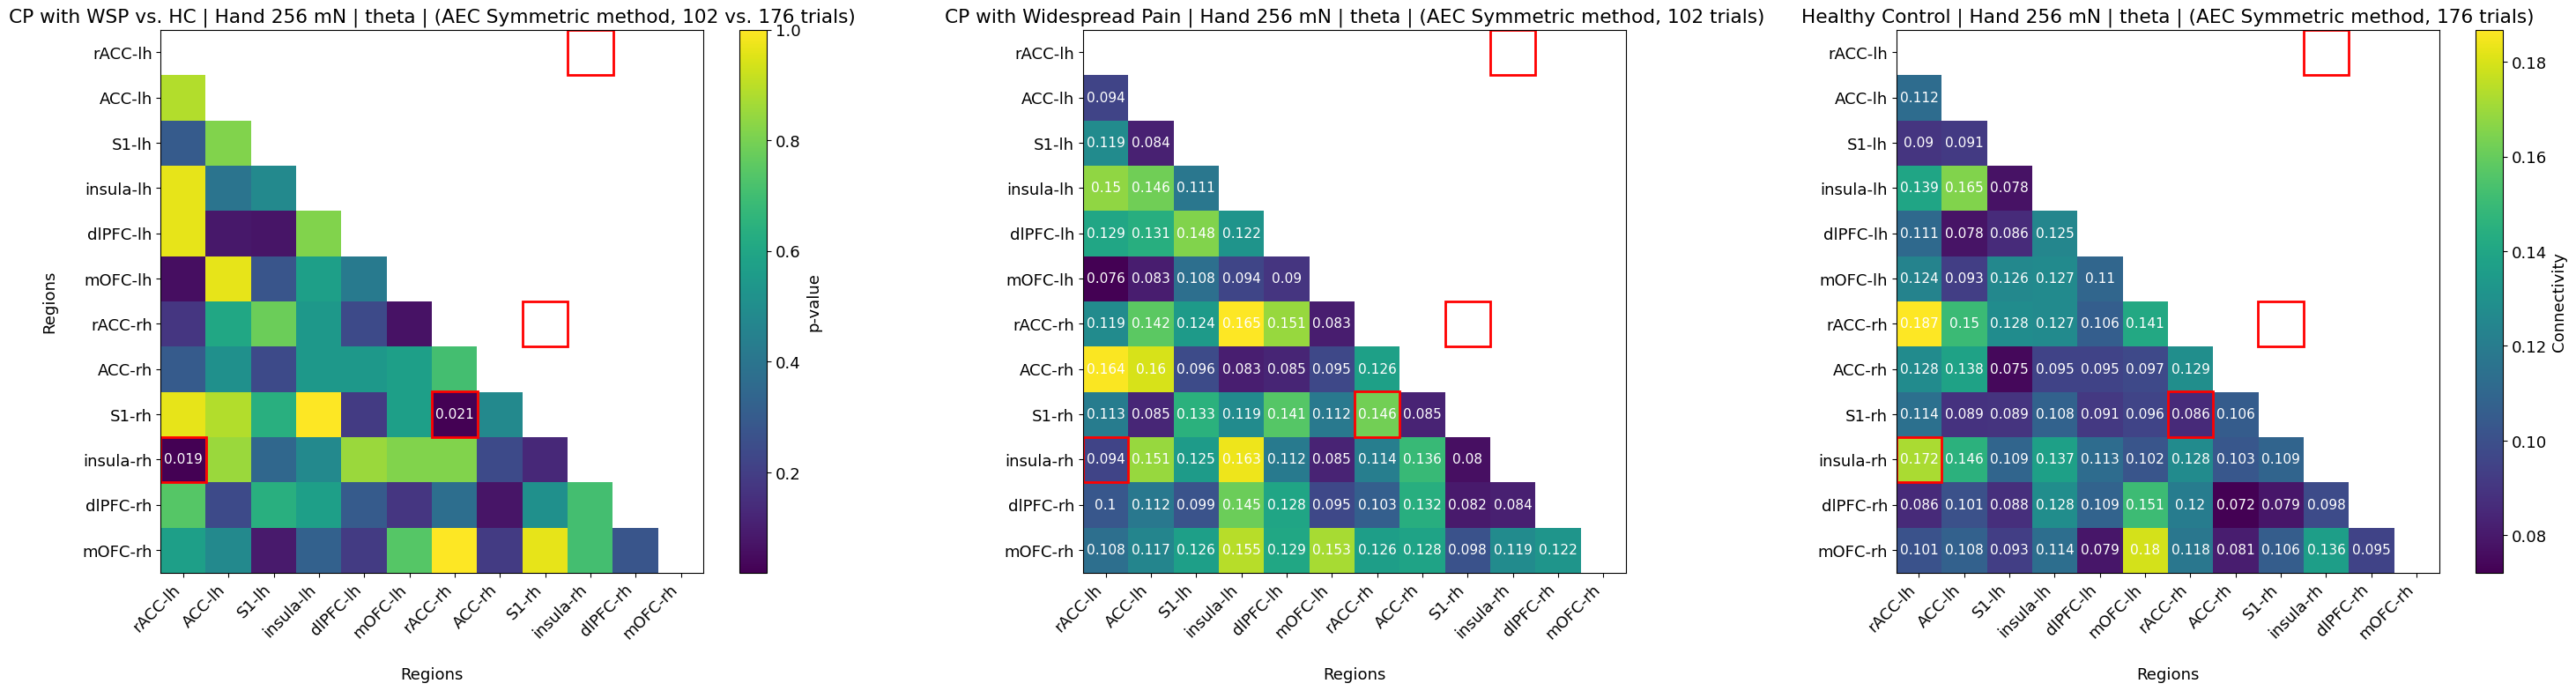

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_symmetric - alpha
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| rACC-lh <-> ACC-lh |  0.006  | 0.059 ± 0.012  | 0.119 ± 0.013  |
| ACC-lh <-> rACC-lh |  0.006  | 0.059 ± 0.012  | 0.119 ± 0.013  |
| ACC-lh <-> ACC-rh  |  0.048  | 0.115 ± 0.021  |  0.173 ± 0.02  |
| ACC-rh <-> ACC-lh  |  0.048  | 0.115 ± 0.021  |  0.173 ± 0.02  |
+--------------------+---------+----------------+----------------+


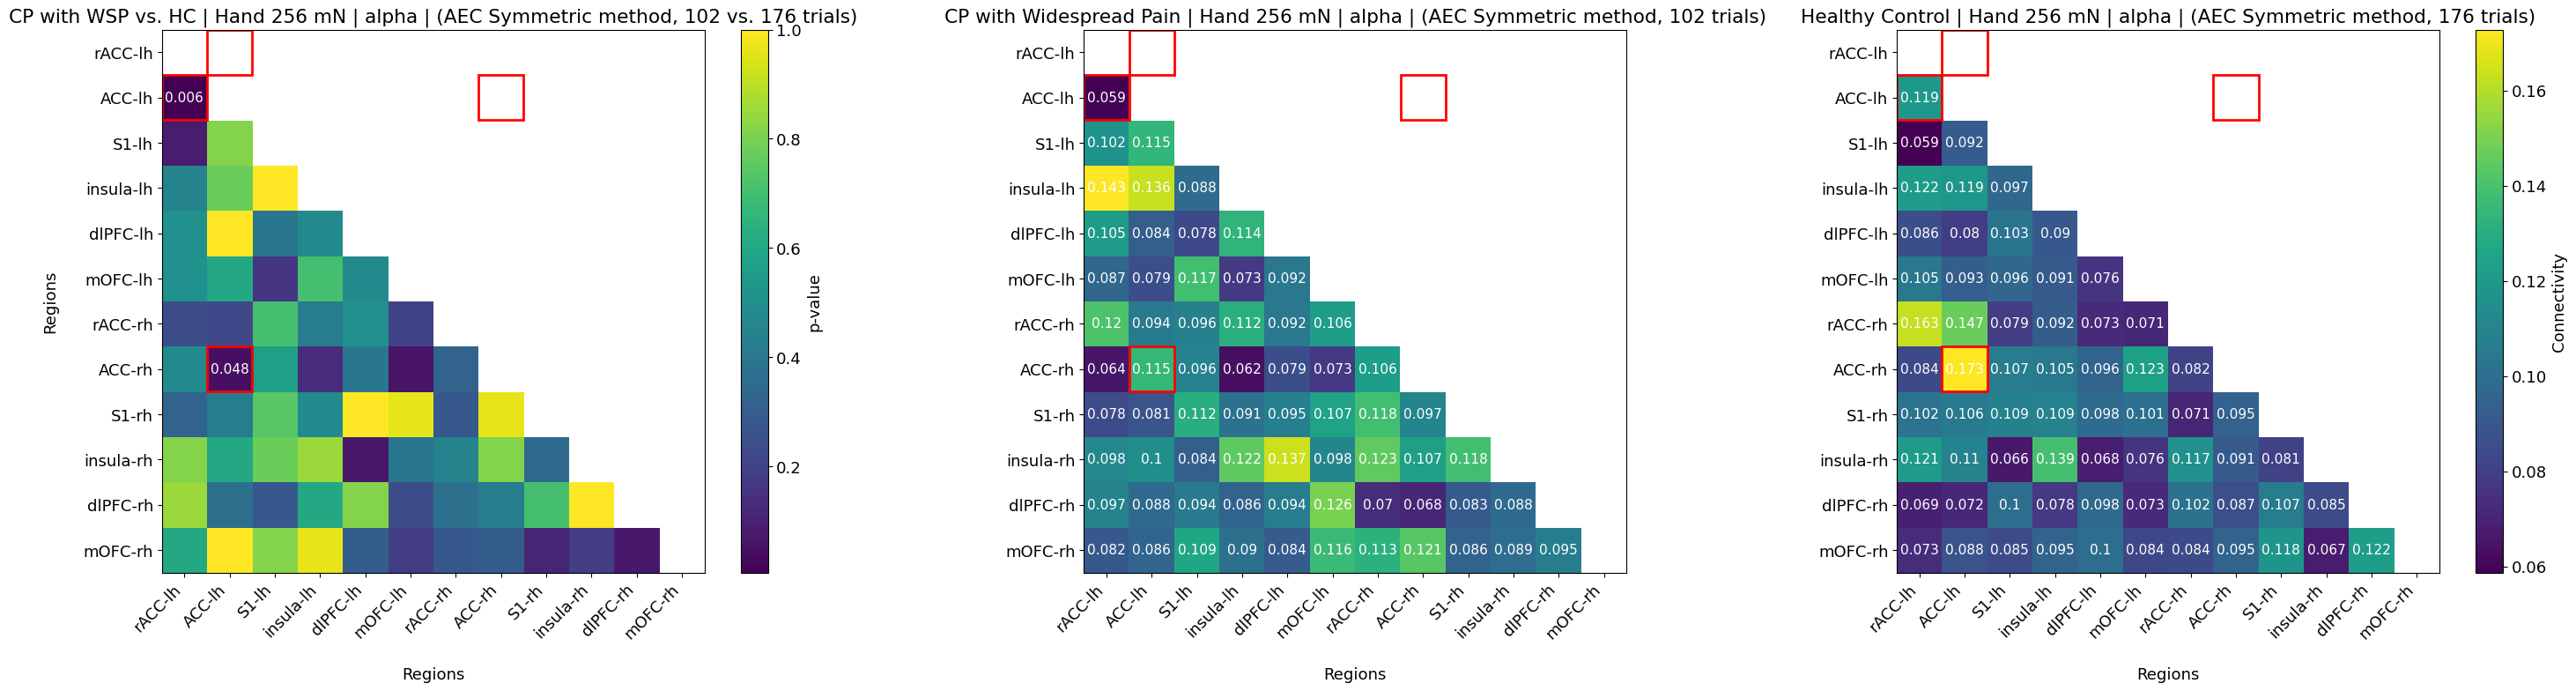

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_symmetric - beta
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|   S1-lh <-> rACC-rh   |  0.034  | 0.073 ± 0.012  | 0.042 ± 0.008  |
| insula-lh <-> mOFC-rh |  0.006  | 0.026 ± 0.005  |  0.063 ± 0.01  |
| mOFC-lh <-> dlPFC-rh  |  0.043  |  0.058 ± 0.01  | 0.038 ± 0.007  |
|   rACC-rh <-> S1-lh   |  0.034  | 0.073 ± 0.012  | 0.042 ± 0.008  |
| dlPFC-rh <-> mOFC-lh  |  0.043  |  0.058 ± 0.01  | 0.038 ± 0.007  |
| mOFC-rh <-> insula-lh |  0.006  | 0.026 ± 0.005  |  0.063 ± 0.01  |
+-----------------------+---------+----------------+----------------+


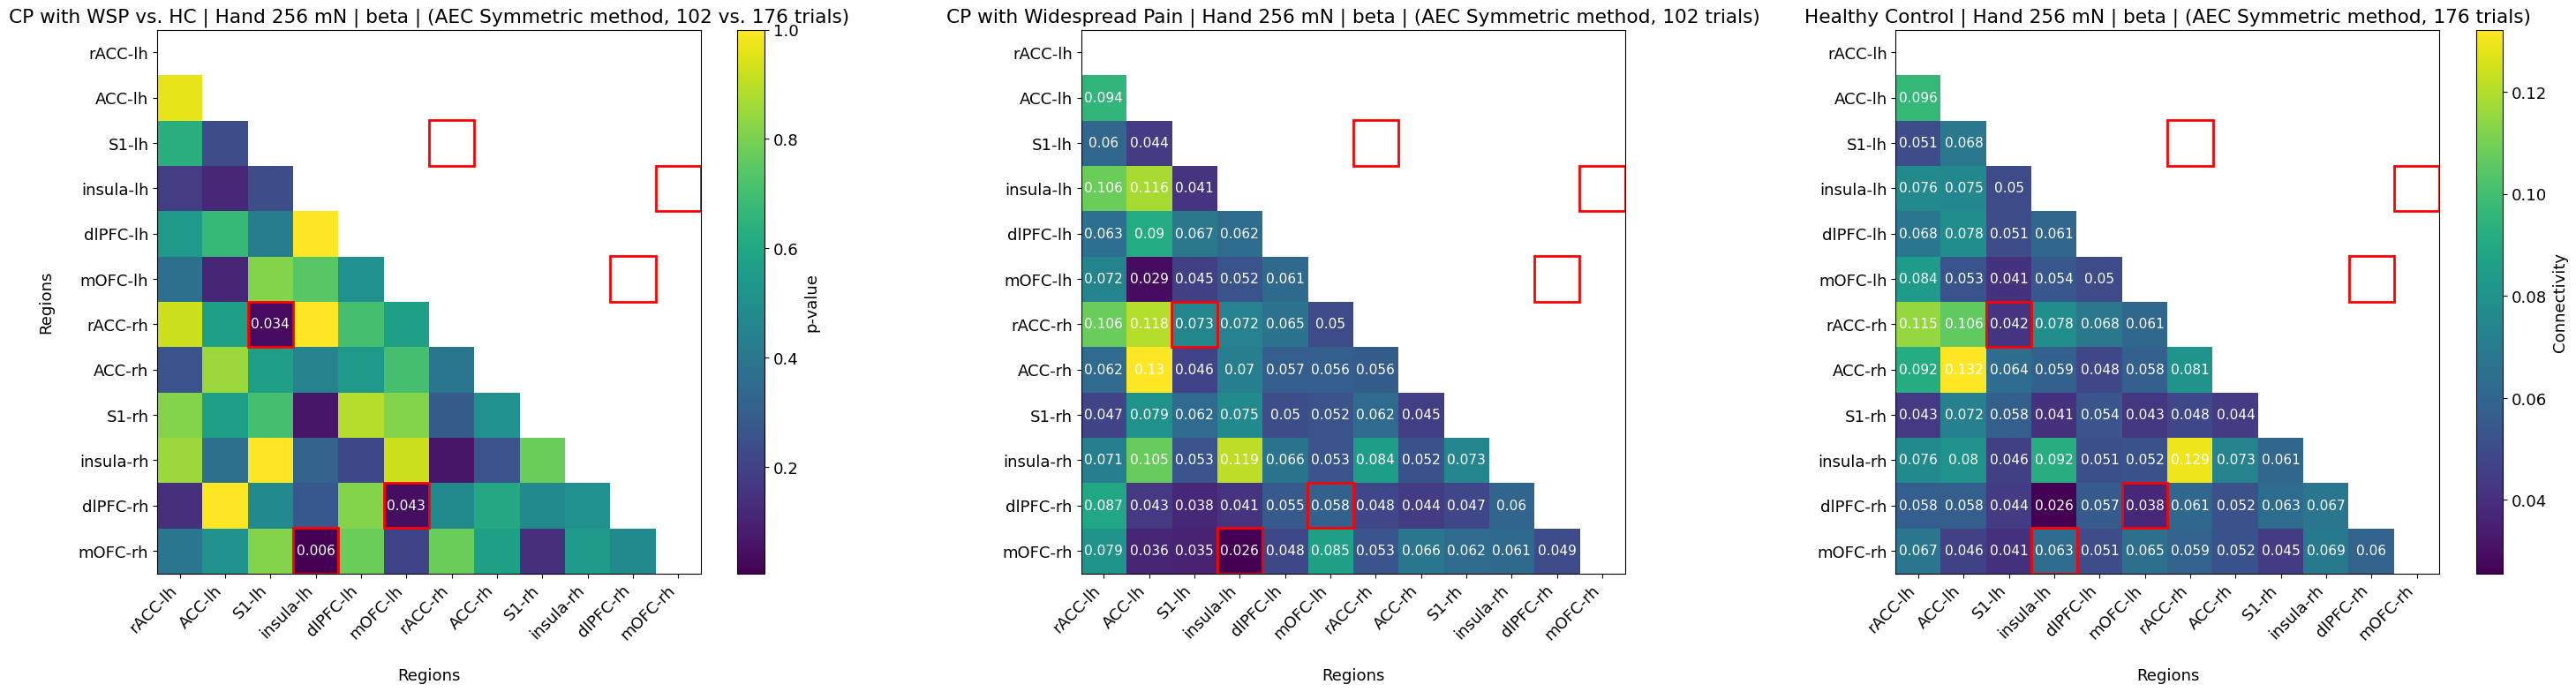

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_symmetric - low-gamma
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| ACC-rh <-> mOFC-rh |  0.048  | 0.033 ± 0.006  |  0.064 ± 0.01  |
| mOFC-rh <-> ACC-rh |  0.048  | 0.033 ± 0.006  |  0.064 ± 0.01  |
+--------------------+---------+----------------+----------------+


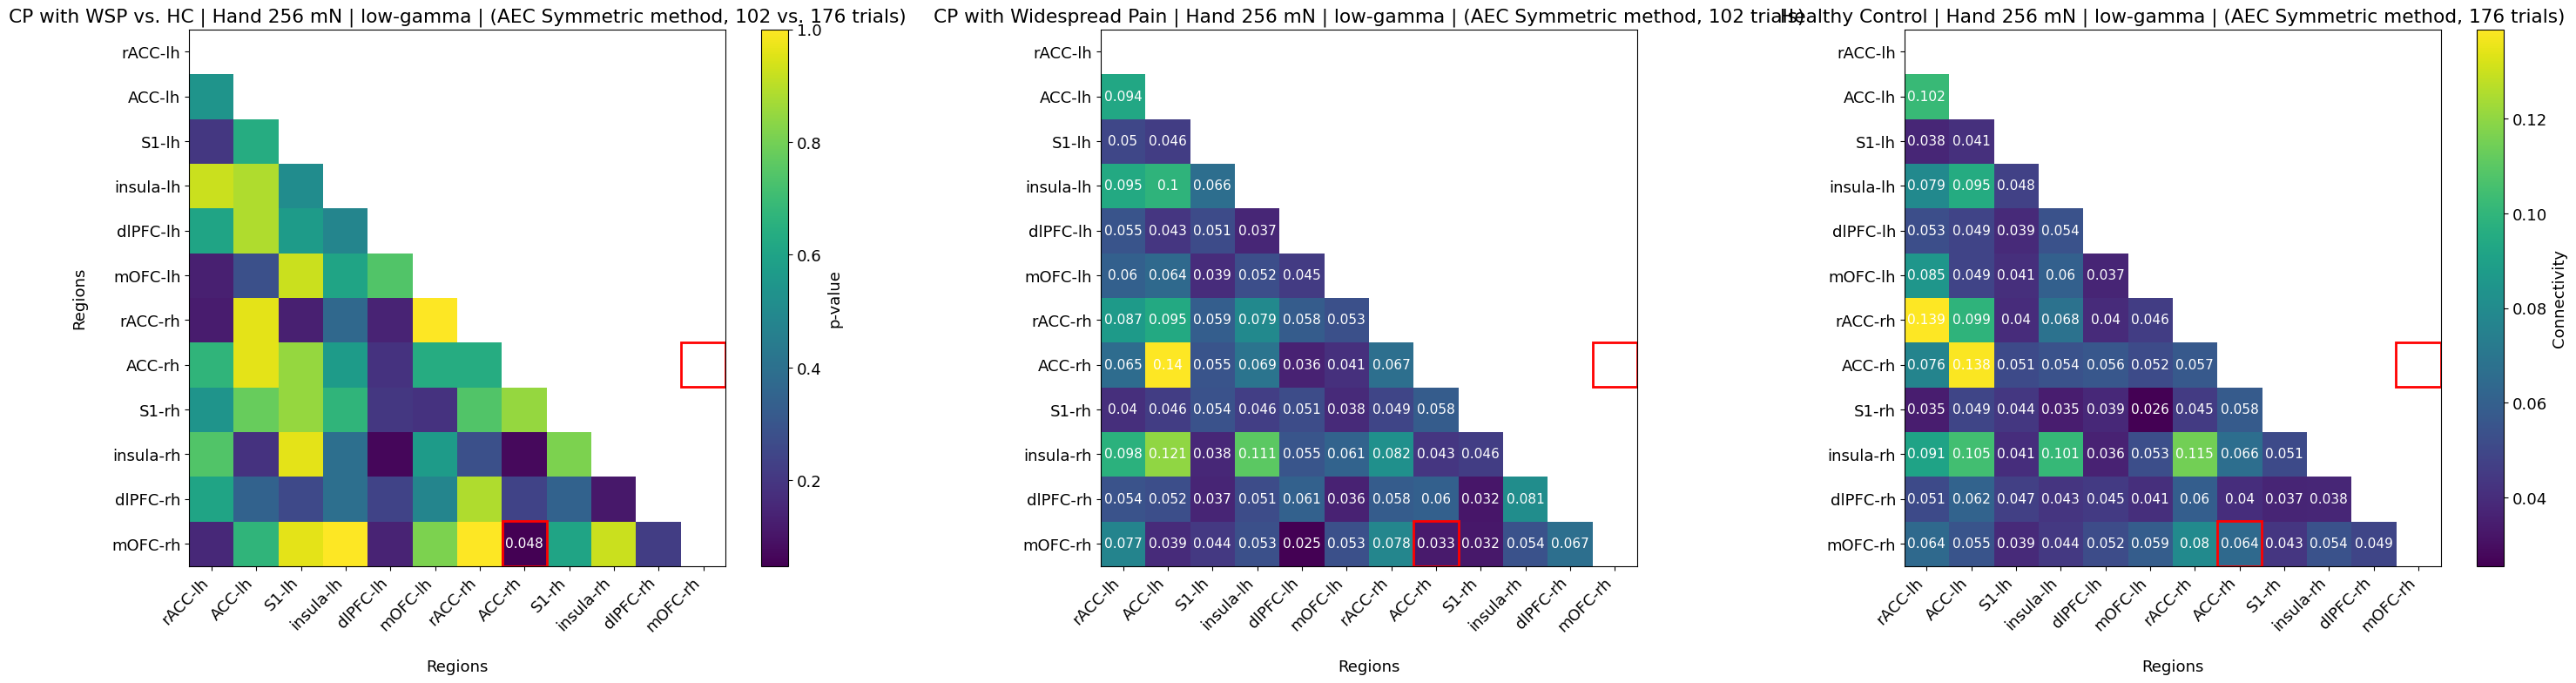

Hand 256 mN - CP with Widespread Pain vs. Healthy Control - aec_symmetric - high-gamma
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|   S1-lh <-> rACC-rh   |  0.011  | 0.023 ± 0.007  | 0.053 ± 0.007  |
| dlPFC-lh <-> dlPFC-rh |  0.007  | 0.042 ± 0.008  | 0.077 ± 0.008  |
|   rACC-rh <-> S1-lh   |  0.011  | 0.023 ± 0.007  | 0.053 ± 0.007  |
| dlPFC-rh <-> dlPFC-lh |  0.007  | 0.042 ± 0.008  | 0.077 ± 0.008  |
+-----------------------+---------+----------------+----------------+


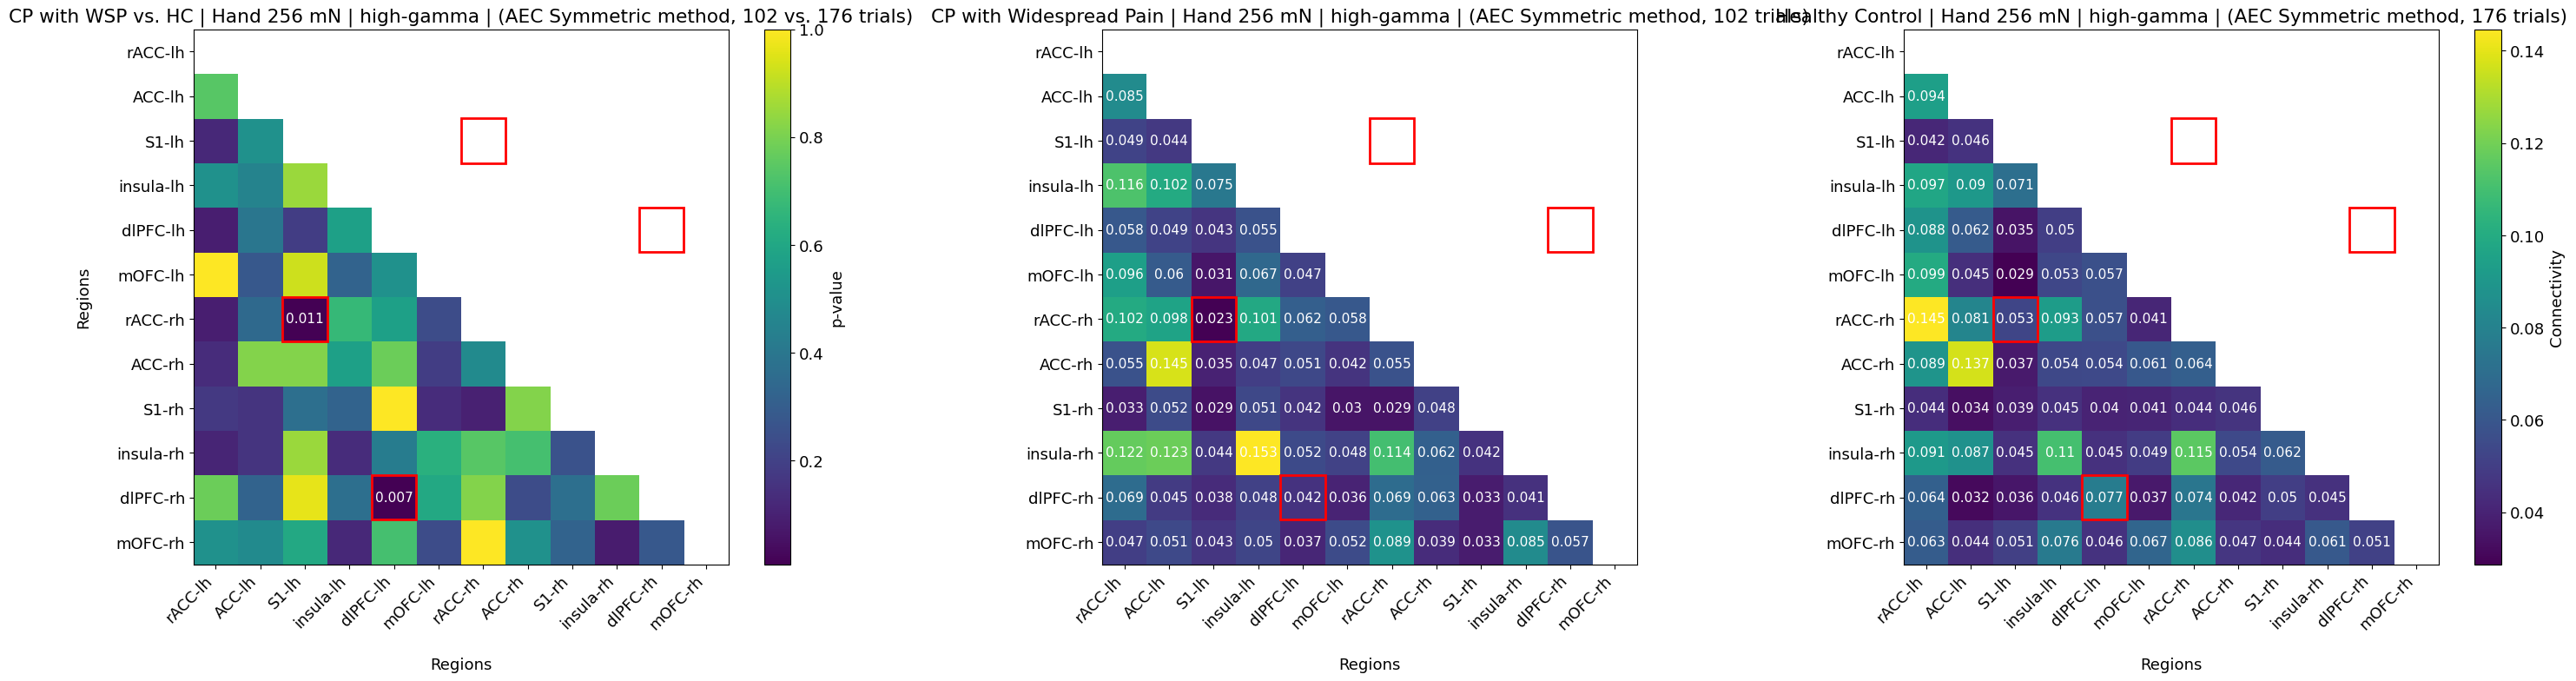

In [27]:
# CP Widespread Pain Hand HS. vs Healthy Control Hand HS
these_group_names = ["CP with Widespread Pain", "Healthy Control","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']

            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP with WSP vs. HC",
                        these_group_names[0], 
                        these_group_names[1],],
                save_names=["Chronic_Pain", 
                            "Healthy_Control", 
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
            )
            
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path / f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)

In [ ]:
# CP Widespread Pain Hand HS. vs CP without Widespread Pain
these_group_names = ["CP with Widespread Pain", "CP without Widespread Pain"]
these_group_cons = [group_con_CP_WSP, group_con_CP_No_WSP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_CP_No_WSP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP w/ WSP vs. CP w/o WSP",
                        these_group_names[0], 
                        these_group_names[1], ],
                save_names=[these_group_names[0], 
                            these_group_names[1],
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
            )
            
            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)